# PROJECT 01 - Soundcloud Project

In [1]:
from bs4 import BeautifulSoup 
import time
import pandas as pd
from selenium import webdriver

**<font size="5">PARSE HTML</font>**

**Idea:**

- Step 1: Create a list of keywords we want to search.

- Step 2: For each keyword in the keywords list, crawl data from "https://soundcloud.com/search/sets?q= + keyword" to find data of some playlists(playlist_id, playlist_title, playlist_url) that match to that keyword.

- Step 3: With each found playlist, crawl data from that playlist_url to find data of maximum 5 tracks(track_id, track_title, track_url) and fill all missing data of that playlist (except userId). 
    - *Note: if there is more than 5 tracks, find only 5 and ignore the rest.

- Step 4: From crawling found playlists and tracks urls, find data of users who own them. If it is track, fill all missing data of that track. If it is playlist, fill playlist's userID.

**Playlist**

| Collumn Name | Description |
| --- | --- |
| id | Playlist ID |
| title | Playlist's tile |
| create_date | Playlist's creation date |
| likes_count | Playlist's number of likes |
| reposts_count | Playlist's number of reposts |
| tracks_count | Playlist's number of tracks |
| total_playtime | Playlist's total playtime |
| tags | Playlist's all tags |
| url | Playlist's URL |
| userId | Playlist's owner userID |
| trackIds | All playlist's trackIDs (maximum 5) |

**Track**

| Collumn Name | Description |
| --- | --- |
| id | Track ID |
| title | Track's tile |
| upload_date | Track's upload date |
| plays_count | Track's number of plays |
| likes_count | Track's number of likes |
| reposts_count | Track's number of reposts |
| comments_count | Track's number of comments |
| tags | Track's all tags |
| userId | Track's owner userID |
| url | Track's URL |

**User**

| Collumn Name | Description |
| --- | --- |
| id | User ID |
| display_name | User's display name |
| followers_count | User's number of followers |
| tracks_count | User's number of tracks |
| url | User's URL |

**Setup**

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument("--mute-audio")

driver = webdriver.Chrome(options=options)
driver.set_page_load_timeout(7)

In [ ]:
homepage_url = "https://soundcloud.com"
track_url = "https://soundcloud.com/search/sounds?q="
artist_url = "https://soundcloud.com/search/people?q="
Playlists_url = "https://soundcloud.com/search/sets?q="

In [ ]:
keywords = ['Vietnam', 'Lofi'   , 'Chill'      , 'Pop'       , 'Kpop', 
            'Hiphop' , 'Anime'  , 'Future Bass', 'Remix'     , 'EDM', 
            'Trap'   , 'Country', 'Jazz'       , 'Blues'     , 'Trance', 
            'Rap'    , 'Rock'   , 'Acoustic'   , 'Electronic', 'Indie', 
            'Dubstep', 'Folk'   , 'Disney'     , 'Bolero'    , 'Beats',
            'Gaming' , 'Japan'  , 'Ambient'    , 'Piano'     , 'Guitar']

In [ ]:
time_sleep = 4

In [ ]:
current_playlist_id = 0
current_track_id = 0
current_user_id = 0

**Get playlist function**

`search_playlists_by_keyword`: return data of some playlists(id, title, url) that match to an input keyword
- Input:
    - keyword.
    - current_playlist_id: add 1 to current_playlist_id to use it in the next funtion.
    
`search_playlists_by_keywords`: return all data of found playlists(id, title, url) by running above function through each keyword in keywords list.
- Input:
    - keywords: list of keywords.
    - current_playlist_id: To assign current_playlist_id to playlist id.

In [ ]:
# Obtains a list of playlists searched by using a keyword
def search_playlists_by_keyword(keyword, current_playlist_id):
    # Empty list contains final result
    _playlists = []
    
    driver.get(Playlists_url + keyword)
    time.sleep(time_sleep)
    driver.execute_script("window.scrollBy(0,document.body.scrollHeight);")
    time.sleep(time_sleep)
    driver.execute_script("window.scrollBy(0,document.body.scrollHeight);")
    time.sleep(time_sleep)
    driver.execute_script("window.scrollBy(0,document.body.scrollHeight);")
    time.sleep(time_sleep)

    soup = BeautifulSoup(driver.page_source)

    # Get playlist items
    search_items = soup.find_all('li', class_='searchList__item sc-mt-3x')
    for item in search_items:
        # Title
        title = ''
        _title = item.find('a', class_='sc-link-primary soundTitle__title sc-link-dark sc-text-h4')
        if _title is not None:
            _title = _title.find('span')
            if _title is not None:
                title = _title.text

        # URL
        url = ''
        _ref = item.find('a', class_='sound__coverArt')
        if _ref is not None:
            url = homepage_url + _ref['href']

        # Add to result if URL isn't already in result
        if url not in [p['url'] for p in _playlists] and url != '':
            _playlists.append({'id':'' ,'title':title, 'create_date':'', 'likes_count':'', 'reposts_count':'',\
                               'tracks_count':'', 'total_playtime':'', 'tags':'', 'url':url, 'userId':'', 'trackIds':''}) 
            current_playlist_id += 1
    
    print('Keyword:', keyword)
    print(len(_playlists), 'playlist(s)\n')
    return _playlists
            
# Obtains a list of playlists searched by using a list of keywords
def search_playlists_by_keywords(keywords, current_playlist_id):
    # Empty list contains final result
    playlists = []
    
    for keyword in keywords:
        rs = search_playlists_by_keyword(keyword, current_playlist_id)
        for r in rs:
            if r not in playlists:
                r['id'] = str(current_playlist_id)
                current_playlist_id +=1
                playlists.append(r)
    
    return playlists

**Get Track function**

`get_tracks_from_playlist`: From input playlist, get playlist URL and fill all missing data of that playlist(except userId), then return data of maximum 5 tracks(title, url) from that playlist.
- Input:
    - playlist

`get_tracks_from_playlists`: return all data of found tracks(id, title, url) by running above function through each playlist in input playlists list.
- Input: 
    - playlists: list of playlists.
    - current_track_id: To assign current_track_id to track id.

In [ ]:
# Max tracks obtains per playlist
tracks_per_playlist = 5

# Obtains a list of tracks inside a playlist
# Update info about that playlist
def get_tracks_from_playlist(playlist):
    # Empty list contains final result
    _tracks = []
    
    driver.get(playlist['url'])
    time.sleep(time_sleep)
    driver.execute_script("scroll(0, 250);")
    time.sleep(time_sleep)
    parse = BeautifulSoup(driver.page_source)
            
    # Create date
    create_date = ''
    _create_date = parse.find('time', class_='relativeTime')
    if _create_date is not None:
        create_date = _create_date['title']

    # Summary: tracks count, total playtime
    tracks_count   = ''
    total_playtime = ''
    summary = parse.find('div', class_='fullHero__tracksSummary')
    if summary is not None:
        _tracks_count = summary.find('div', class_='genericTrackCount__title')
        if _tracks_count is not None:
            tracks_count   = _tracks_count.text.replace(',', '')
        _total_playtime = summary.find('div', class_='genericTrackCount__duration')
        if _total_playtime is not None:
            total_playtime = _total_playtime.text

    # Tags
    tags = ''
    _tags = parse.find_all('span', class_='sc-truncate sc-tagContent')
    if len(_tags) > 0:
        tags = ', '.join([t.text for t in _tags])

    # Playlist stats: likes, reposts
    likes_count   = '0'
    reposts_count = '0'
    stats_area = parse.find('ul', attrs={'aria-label':'Playlist stats'})
    if stats_area is not None:
        stats = stats_area.find_all('li', class_='sc-ministats-item')
        for stat in stats:
            if 'like' in stat['title']:
                likes_count = stat['title'].rstrip('s').rstrip(' like').replace(',', '')
            elif 'repost' in stat['title']:
                reposts_count = stat['title'].rstrip('s').rstrip(' repost').replace(',', '')

    # Update playlist
    playlist['create_date']    = create_date
    playlist['tracks_count']   = tracks_count
    playlist['total_playtime'] = total_playtime
    playlist['likes_count']    = likes_count
    playlist['reposts_count']  = reposts_count
    playlist['tags']           = tags

    # Get track items
    track_items = parse.find_all('div', class_='trackItem__content sc-truncate', limit=tracks_per_playlist)
    for track_item in track_items:

        # Skip geoblocked track items
        track_item_additional = track_item.find_next_sibling('div', class_='trackItem__additional')
        if track_item_additional is not None:
            if track_item_additional.find('span', class_='trackItem__blockMsg g-geoblocked-icon') is not None:
                continue

        title_url = track_item.find('a', class_='trackItem__trackTitle sc-link-dark sc-link-primary sc-font-light')

        track_title = ''
        track_url   = ''
        if title_url is not None:
            track_title = title_url.text
            track_href  = title_url['href']
            i = track_href.find('?')
            if i != -1:
                track_href = track_href[0:i]
            track_url = homepage_url + track_href

        # Add to result if URL isn't already in result or invalid
        if track_url not in [track['url'] for track in _tracks] and track_url != '':
            _tracks.append({'id':'', 'title':track_title, 'upload_date':'', 'plays_count':'', 'likes_count':'',\
                            'reposts_count':'', 'comments_count':'', 'tags':'', 'userId':'', 'url':track_url})

    
    print('Playlist:', playlist['url'])
    print(len(_tracks), 'track(s)\n')
    return _tracks

# Obtains a list of tracks from a list of playlists
# Update info about those playlists
def get_tracks_from_playlists(playlists, current_track_id):
    # Empty list contains final result
    tracks = []
    
    for playlist in playlists:
        rs = get_tracks_from_playlist(playlist)
        for r in rs:
            
            not_in = True
            in_idx = None
            for i in range(len(tracks)):
                if r['url'] == tracks[i]['url']:
                    not_in = False
                    in_idx = i
            
            if not_in:
                r['id'] = str(current_track_id)
                current_track_id += 1
                tracks.append(r)
                if playlist['trackIds'] == '':
                    playlist['trackIds'] = r['id']
                else:
                    playlist['trackIds'] += ',' + r['id']
            else:
                if playlist['trackIds'] == '':
                    playlist['trackIds'] = tracks[in_idx]['id']
                else:
                    playlist['trackIds'] += ',' + tracks[in_idx]['id']


    return tracks

**Get User function**

`get_user_from_track_or_playlist`: From input track or playlist. If it is track, fill all missing data of that track(except userId) then return data of that track's user(display_name, followers_count, tracks_count, url). IF it is playlist, only return data of that playlist's user.
- Input:
    - track=None
    - playlist=None
    
`get_users_from_tracks`: Fill track userId, return current_user_id and all data of found user by running `get_user_from_track_or_playlist` function through each track in a tracks list.
- Input:
    - tracks: a list of tracks.
    - current_user_id: To assign current_user_id to user id.
    - users: a list of users

`get_users_from_playlists`: Fill playlist userId, return current_user_id and all data of found user by running `get_user_from_track_or_playlist` function through each playlist in a playlists list.
- Input:
    - playlists: a list of playlists.
    - current_user_id: To assign current_user_id to user id.
    - users: a list of users.

In [ ]:
# Obtains a list of users from a track
# Update info about that track
def get_user_from_track_or_playlist(track=None, playlist=None):
    # Create session
    obj = None
    print_out = None
    if track != None:
        obj = track
        print_out = "Track:"
    elif playlist != None:
        obj = playlist
        print_out = "Playlist:"
    else:
        return None

    driver.get(obj['url'])
    time.sleep(time_sleep)
    parse = BeautifulSoup(driver.page_source)

    if track != None:

        # Update date
        upload_date = ''
        _upload_date = parse.find('time', class_='relativeTime')
        upload_date = _upload_date['title']

        # Track stats: likes, reposts, plays
        likes_count   = '0'
        reposts_count = '0'
        plays_count   = '0'
        stats_area = parse.find('ul', attrs={'aria-label':'Track stats'})
        if stats_area is not None:
            stats = stats_area.find_all('li', class_='sc-ministats-item')
            for stat in stats:
                if 'like' in stat['title']:
                    likes_count = stat['title'].rstrip('s').rstrip(' like').replace(',', '')
                elif 'repost' in stat['title']:
                    reposts_count = stat['title'].rstrip('s').rstrip(' repost').replace(',', '')
                elif 'play' in stat['title']:
                    plays_count = stat['title'].rstrip('s').rstrip(' play').replace(',', '')

        # Comments
        comments_count = '0'
        _comments_count = parse.find('span', class_='commentsList__actualTitle')
        if _comments_count is not None:
            comments_count = _comments_count.text.rstrip('s').rstrip(' comment').replace(',', '')

        # Tags
        tags = ''
        _tags = parse.find_all('span', class_='sc-truncate sc-tagContent')
        if len(_tags) > 0:
            tags = ', '.join([t.text for t in _tags])

        # Update track
        track['upload_date']    = upload_date
        track['likes_count']    = likes_count
        track['reposts_count']  = reposts_count
        track['plays_count']    = plays_count
        track['comments_count'] = comments_count
        track['tags']           = tags

    # User content: display name, url, followers, tracks count
    user_display_name = ''
    user_url          = ''
    user_followers_count = '0'
    user_tracks_count    = '0'
    user_content = parse.find('div', class_='userBadge__content sc-media-content')
    if user_content is not None:
        _user_display_name = user_content.find('span')
        if _user_display_name is not None:
            user_display_name = _user_display_name.text
        _ref = user_content.find('a')
        if _ref is not None:
            user_url = homepage_url + _ref['href']

        user_stats = user_content.find_all('li', class_='sc-ministats-item')
        for user_stat in user_stats:
            if 'follower' in user_stat['title']:
                user_followers_count = user_stat['title'].rstrip('s').rstrip(' follower').replace(',', '')
            elif 'track' in user_stat['title']:
                user_tracks_count = user_stat['title'].rstrip('s').rstrip(' track').replace(',', '')
    else:
        print('No')
    
    
    
    print(print_out, obj['url'])
    print('User:', user_display_name, '(', user_url, ')\n')
    return {'id':'', 'display_name':user_display_name, 'followers_count':user_followers_count,\
            'tracks_count':user_tracks_count, 'url':user_url}
            
# Obtains a list of users from a list of tracks
# Update info about those tracks
def get_users_from_tracks(tracks, current_user_id, users=[]):
    for track in tracks:
        user = get_user_from_track_or_playlist(track=track)
            
        not_in = True
        in_idx = None
        for i in range(len(users)):
            if user['url'] == users[i]['url']:
                not_in = False
                in_idx = i

        if not_in:
            user['id'] = str(current_user_id)
            current_user_id += 1
            users.append(user)
            track['userId'] = user['id']
        else:
            track['userId'] = users[in_idx]['id']
    
    return users, current_user_id

# Obtains a list of users from a list of tracks
def get_users_from_playlists(playlists, current_user_id, users=[]):
    for playlist in playlists:
        user = get_user_from_track_or_playlist(playlist=playlist)

        not_in = True
        in_idx = None
        for i in range(len(users)):
            if user['url'] == users[i]['url']:
                not_in = False
                in_idx = i

        if not_in:
            user['id'] = str(current_user_id)
            current_user_id += 1
            users.append(user)
            playlist['userId'] = user['id']
        else:
            playlist['userId'] = users[in_idx]['id']
    
    return users, current_user_id

In [ ]:
playlists = search_playlists_by_keywords(keywords, current_playlist_id)

In [ ]:
tracks    = get_tracks_from_playlists(playlists, current_track_id)

In [ ]:
users, current_user_id     = get_users_from_tracks(tracks=tracks, current_user_id=current_user_id)

In [ ]:
users, current_user_id     = get_users_from_playlists(playlists=playlists, current_user_id=current_user_id, users=users)

In [ ]:
driver.close()

In [ ]:
print('Found: ')
print(' - ', len(playlists), 'playlist(s)')
print(' - ', len(tracks), 'track(s)')
print(' - ', len(users), 'user(s)')

df1 = pd.DataFrame(playlists)
df1.to_csv('Crawl_data/playlist.csv', index=False)

df2 = pd.DataFrame(tracks)
df2.to_csv('Crawl_data/track.csv', index=False)

df3 = pd.DataFrame(users)
df3.to_csv('Crawl_data/user.csv', index=False)

In [ ]:
df_playlist = pd.read_csv('Crawl_data/playlist.csv')
df_playlist

In [ ]:
df_track = pd.read_csv('Crawl_data/track.csv')
df_track

In [ ]:
df_user = pd.read_csv('Crawl_data/user.csv')
df_user

---

**<font size="5">Explore Data</font>**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime
import statistics
import seaborn as sns
from matplotlib import cycler

### Data Analysis Checklist:
- Check the data type whether it is matched with each attribute or not.
- Check the null values and the duplicate values.
- Check the outlier values.
- Check univariate and multivariate correlations.

### Questions about data set:
- Did you clearly understand the attributes in your data sets?
- Have you considered whether the question can be answered with the available data?

### Data preprocessing:
#### Read data from file:

In [3]:
user_df = pd.read_csv('user.csv')
user_df = user_df.set_index('id')

rows, cols = user_df.shape
print('Number of Rows: ', rows)
print('Number of Columns: ', cols)
user_df.head()

Number of Rows:  4439
Number of Columns:  4


,display_name,followers_count,tracks_count,url
id,,,,
0,H u ệ N i n h,1339,6,https://soundcloud.com/hueninh2012
1,phmnganh,904,5,https://soundcloud.com/nguyen-pham-phuong-anh-...
2,I'm s̶.̶o̶w̶h̶o̶w̶a̶s̶b̶o̶r̶n̶a̶t̶ Chris t̶m̶a̶s̶,191,9,https://soundcloud.com/chris-hoang-2412
3,Kina,120743,68,https://soundcloud.com/kinabeats
4,frad,22246,36,https://soundcloud.com/fradical


---

In [4]:
playlist_df = pd.read_csv('playlist.csv')
playlist_df = playlist_df.set_index('id')

rows, cols = playlist_df.shape
print('Number of Rows: ', rows)
print('Number of Columns: ', cols)
playlist_df.head()

Number of Rows:  1196
Number of Columns:  10


,title,create_date,likes_count,reposts_count,tracks_count,total_playtime,tags,url,userId,trackIds
id,,,,,,,,,,
0,Lo-Fi Vietnam Chill,10 September 2019,31745,1217,48,2:55:36,"Soundtrack, Soul, Lo-Fi, Acid, Relax, vietnam",https://soundcloud.com/winterhihiihiii/sets/lo...,3354,"0,1,2,3,4"
1,vietnam,8 April 2019,8,0,340,2:17:33,NaN,https://soundcloud.com/thang-bui-667476417/set...,3355,"5,6,7,8,9"
2,Vietnam,31 July 2020,4,0,297,2:02:49,NaN,https://soundcloud.com/sammmv/sets/vietnam,3356,"10,11,12,13,14"
3,Viet Nam,24 April 2020,7,0,427,2:14:05,NaN,https://soundcloud.com/minh-t-nguy-n-857855647...,3357,"15,16,17,18,19"
4,Vietnam,25 November 2019,9,0,247,2:07:48,NaN,https://soundcloud.com/ngan-hoang-810603610/se...,3358,"20,21,22,23,24"


---

In [5]:
track_df = pd.read_csv('track.csv')
track_df = track_df.set_index('id')

rows, cols = track_df.shape
print('Number of Rows: ', rows)
print('Number of Columns: ', cols)
track_df.head()

Number of Rows:  4530
Number of Columns:  9


,title,upload_date,plays_count,likes_count,reposts_count,comments_count,tags,userId,url
id,,,,,,,,,
0,Đi đâu chẳng thấy - Summer Vee,8 September 2019,2859429,34615,878,1438,Indie,0,https://soundcloud.com/hueninh2012/di-dau-chan...
1,Ai biết - WEAN,1 September 2019,7417706,62050,2045,1026,NaN,1,https://soundcloud.com/nguyen-pham-phuong-anh-...
2,Nhỏ trên hạnh phúc...,22 March 2019,722587,4501,91,136,Lo-Fi,2,https://soundcloud.com/chris-hoang-2412/nho-tr...
3,Kina - get you the moon (ft. Snow),14 March 2018,64441358,881570,19862,25090,"Indie, love",3,https://soundcloud.com/kinabeats/kina-get-you-...
4,First Date (out on spotify),21 April 2018,4140664,53978,1744,2013,"<3, lofi, Hip-hop &Rap, cute, jazz, kawaii, de...",4,https://soundcloud.com/fradical/first-date


---

# Does the data have duplicated rows?

In [6]:
user_indx_dup = user_df.index.duplicated().sum()
playlist_indx_dup = playlist_df.index.duplicated().sum()
track_index_dup = track_df.index.duplicated().sum()

print("Number of duplicated index of User DataFrame: ", user_indx_dup)
print("Number of duplicated index of Playlist DataFrame: ", playlist_indx_dup)
print("Number of duplicated index of Track DataFrame: ", track_index_dup)

Number of duplicated index of User DataFrame:  0
Number of duplicated index of Playlist DataFrame:  0
Number of duplicated index of Track DataFrame:  0


*As you can see, there is no duplicated index from these DataFrames.*

Next we check for duplicated row

In [7]:
user_dup = user_df.duplicated().sum()
playlist_dup = playlist_df.duplicated().sum()
track_dup = track_df.duplicated().sum()

print('Number of Duplicated Rows of User DataFrame: ', user_dup)
print('Number of Duplicated Rows of Playlist DataFrame: ', playlist_dup)
print('Number of Duplicated Rows of Track DataFrame: ', user_dup)

Number of Duplicated Rows of User DataFrame:  0
Number of Duplicated Rows of Playlist DataFrame:  21
Number of Duplicated Rows of Track DataFrame:  0


*As you can see, there is 21 duplicated data from Playlist DataFrame.*

Now we drop all duplicated data from Playlist DataFrame

In [8]:
playlist_df = playlist_df.drop_duplicates()

In [9]:
playlist_dup = playlist_df.duplicated().sum()
print('Number of Duplicated Rows of Playlist DataFrame: ', playlist_dup)

Number of Duplicated Rows of Playlist DataFrame:  0


*Now there is no duplicated data.*

---

# Initial Datatypes of DataFrames

1. User_DataFrame (user_df)

In [10]:
user_df.dtypes

display_name       object
followers_count     int64
tracks_count        int64
url                object
dtype: object

---

2. Playlist_DataFrame (playlist_df)

In [11]:
playlist_df.dtypes

title             object
create_date       object
likes_count        int64
reposts_count      int64
tracks_count       int64
total_playtime    object
tags              object
url               object
userId             int64
trackIds          object
dtype: object

We have to:

- *create_date changes from object to datetime*


- *total_playtime changes from object to datetime*

---

3. Track_DataFrame (track_df)

In [12]:
track_df.dtypes

title             object
upload_date       object
plays_count        int64
likes_count        int64
reposts_count      int64
comments_count    object
tags              object
userId             int64
url               object
dtype: object

We have to:

- *create_date changes from object to datetime*


- *total_playtime changes from object to datetime*

---

# Preprocessing

1. playlist_df

In [13]:
# Create_date changes from object to datetime
playlist_df['create_date'] = pd.to_datetime(playlist_df['create_date'], infer_datetime_format = True)

In [14]:
# total_playtime changes from object to datetime
playlist_df['total_playtime'] = pd.to_datetime(playlist_df['total_playtime'], format = '%H:%M:%S', errors = 'coerce')

In [15]:
playlist_df.dtypes

title                     object
create_date       datetime64[ns]
likes_count                int64
reposts_count              int64
tracks_count               int64
total_playtime    datetime64[ns]
tags                      object
url                       object
userId                     int64
trackIds                  object
dtype: object

2. track_df

In [16]:
# After checking the column upload_date, there are many format "Posted on + Day+ Month + Year", different from almost value called "Day + Month + Year"
# Therefore, we remove "Posted on" in order to keep the format of column upload_date
track_df['upload_date'] = track_df.apply(lambda row: row['upload_date'].replace('Posted on ', ''), axis = 1)

In [17]:
# Finally, we can  change the datatype of column upload_date to datetime now
track_df['upload_date'] = pd.to_datetime(track_df['upload_date'], infer_datetime_format = True)

In [18]:
track_df = track_df.replace('C', np.NaN)
track_df['comments_count'] = pd.to_numeric(track_df['comments_count'])

In [19]:
track_df.dtypes

title                     object
upload_date       datetime64[ns]
plays_count                int64
likes_count                int64
reposts_count              int64
comments_count           float64
tags                      object
userId                     int64
url                       object
dtype: object

3. user_df

In [20]:
user_df.dtypes

display_name       object
followers_count     int64
tracks_count        int64
url                object
dtype: object

Now we already preprocessed Data

---

# Missing Data

In [21]:
user_df.isnull().sum()

display_name       0
followers_count    0
tracks_count       0
url                0
dtype: int64

In [22]:
playlist_df.isnull().sum()

title               0
create_date         0
likes_count         0
reposts_count       0
tracks_count        0
total_playtime    178
tags              900
url                 0
userId              0
trackIds           98
dtype: int64

In [23]:
track_df.isnull().sum()

title               0
upload_date         0
plays_count         0
likes_count         0
reposts_count       0
comments_count     13
tags              644
userId              0
url                 0
dtype: int64

We have observed and decided that there are a little bit of data with incorrect format, so we set those values are None.  
There are just only 178 total_playtime and 13 comments_count incorrect format.  
Also, tags is optional for user so each track or each playlist is not necessary to include tag.  
Therefore, it would not effect on our Exploratory Data Analysis

---

# Outliers Removal

### Check user.csv file

<AxesSubplot:>

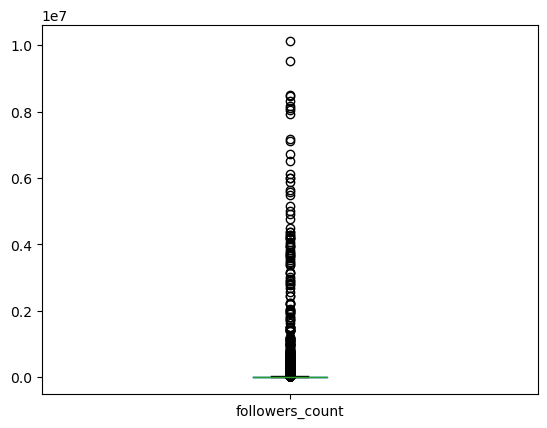

In [24]:
# followers_count check(in user.csv file)
user_df['followers_count'].plot(kind='box')

<AxesSubplot:>

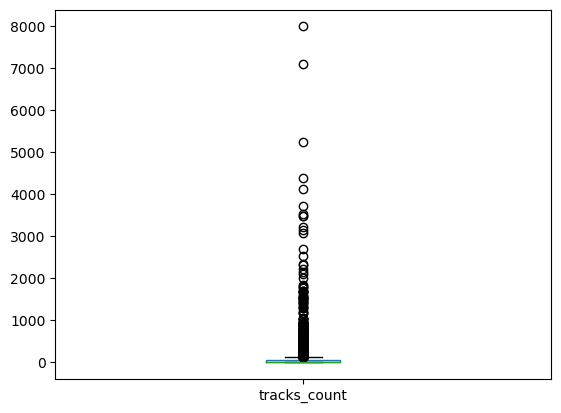

In [25]:
# tracks_count check(in user.csv file)
user_df['tracks_count'].plot(kind='box')

### Check playlist.csv file

<AxesSubplot:>

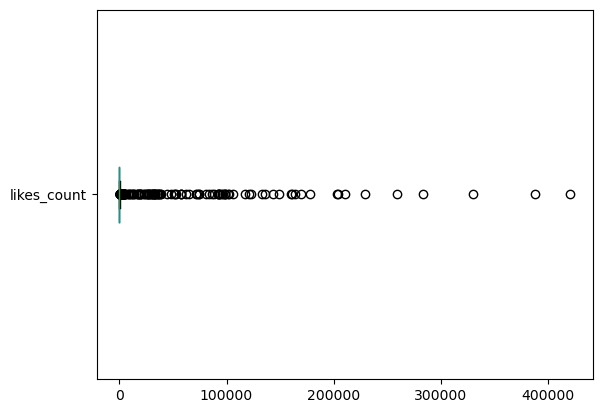

In [26]:
# likes_count check(in playlist.csv file)
playlist_df['likes_count'].plot(kind='box', vert = False)

<AxesSubplot:>

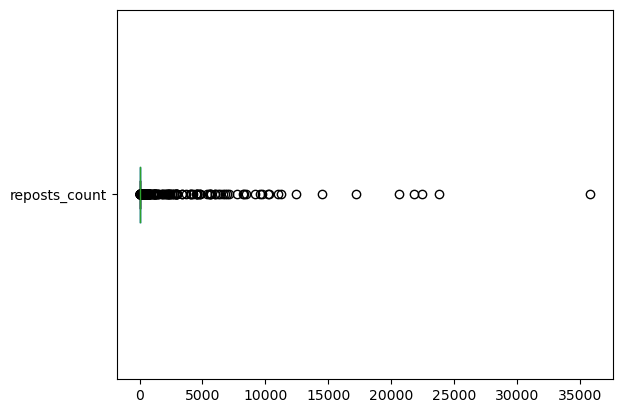

In [27]:
# reposts_count check(in playlist.csv file)
playlist_df['reposts_count'].plot(kind='box', vert = False)

<AxesSubplot:>

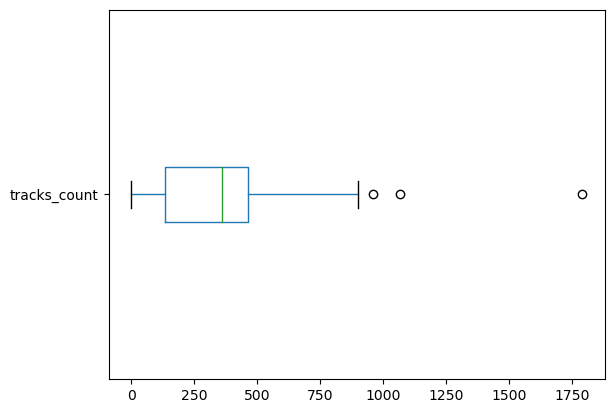

In [28]:
# tracks_count check(in playlist.csv file)
playlist_df['tracks_count'].plot(kind='box', vert = False)

### Check track.csv file

<AxesSubplot:>

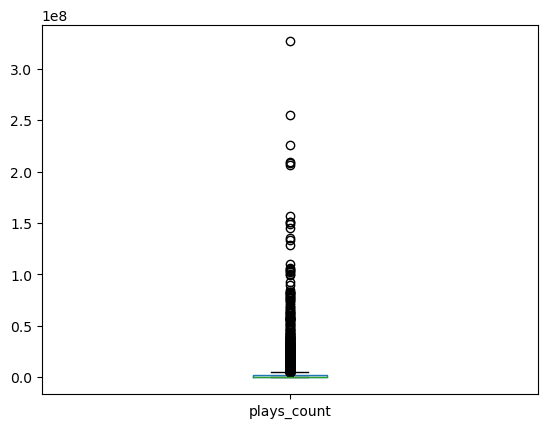

In [29]:
# plays_count check(in track.csv file)
track_df['plays_count'].plot(kind='box')

<AxesSubplot:>

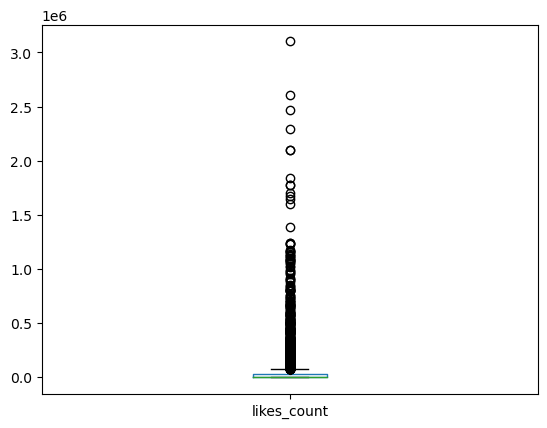

In [30]:
# likes_count check(in track.csv file)
track_df['likes_count'].plot(kind='box')

<AxesSubplot:>

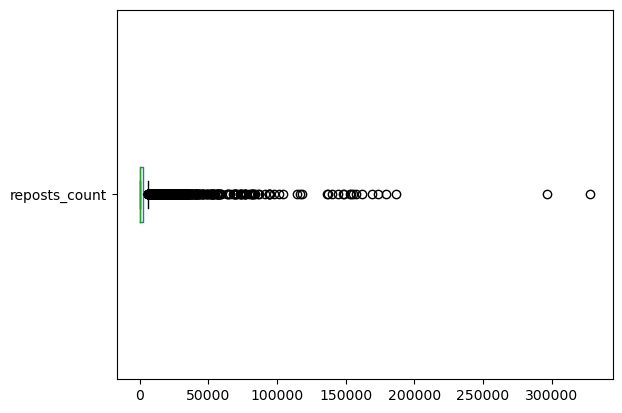

In [31]:
# reposts_count check(in track.csv file)
track_df['reposts_count'].plot(kind='box', vert = False)

<AxesSubplot:>

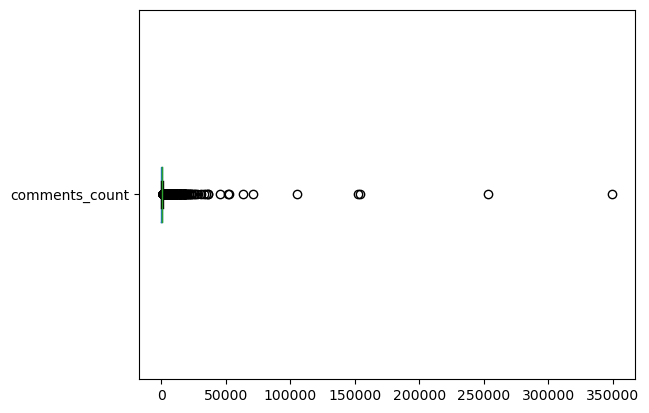

In [32]:
# comments_count check(in track.csv file)
track_df['comments_count'].plot(kind='box', vert = False)

All the Data we have parsed from the SoundCloud website was all reasonable, there is no outlier which is irrational for Statistics.

---

# Questioning

### User information:
- id: ID của user
- display_name: tên hiển thị của user
- followers_count: số lượt follow của user
- tracks_count: số track user đã tạo
- url: đường dẫn của user 

### Playlist information:
- id: ID của playlist
- title: tên playlist
- created_date: ngày tạo playlist
- likes_count: số lượt thích của playlist
- reposts_count: số lượt repost của playlist
- tracks_count: số lượng track của playlist
- total_playtime: thời gian chạy playlist (đơn vị ms)
- tags: các tags tìm kiếm playlist
- url: Đường dẫn của playlist
- userId: ID user của playlist
- trackIds: tên user của playlist

### Track information:
- id: ID của track
- title: tên track
- upload_date: ngày upload track
- plays_count: số lượt nghe của track
- likes_count: số lượt thích của track
- reposts_count: số lượt repost của track
- comments_count: số lượt comments của track
- tags: các tags tìm kiếm của track
- userId: ID user của track
- url: đường dẫn của track

---

**Question: Correlation between number of tracks released and number of followers of one User**

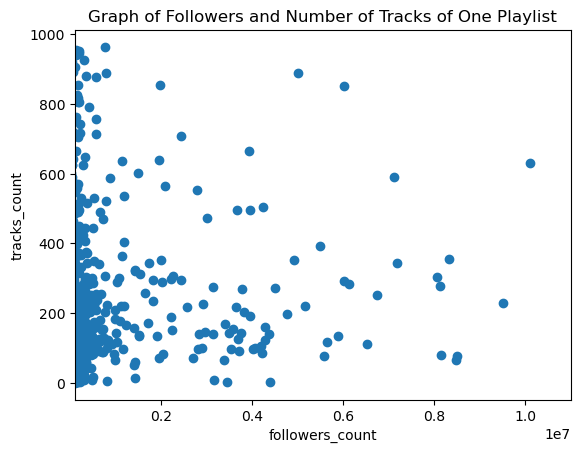

In [33]:
valid_user = user_df[user_df['tracks_count'] <= 1000]
x = valid_user['followers_count']
y = valid_user['tracks_count']
plt.scatter(y = valid_user['tracks_count'], x = valid_user['followers_count'])
plt.ylabel('tracks_count')
plt.xlabel('followers_count')
plt.xlim(100000, 11000000)
plt.title('Graph of Followers and Number of Tracks of One Playlist')
plt.show()

Overally, we could see number of tracks released does not impact on number of followers.  
First, SoundCloud is an open platform for everyone to upload Music, anyone could upload it, especially, underground or amatuer artist.  
Secondly, In reality, this makes no sense that the more you upload, the more followers you get.

**Question: Are most followers-artists famous singers, prestigious record producers**

In [34]:
famous_artists = user_df.nlargest(50, 'followers_count')
famous_artists

,display_name,followers_count,tracks_count,url
id,,,,
896,Future,10111739,631,https://soundcloud.com/futureisnow
1772,Big Sean,9517111,229,https://soundcloud.com/bigsean-1
664,Def Jam Recordings,8498855,76,https://soundcloud.com/defjam
1343,YMCMB-Official,8465146,66,https://soundcloud.com/ymcmbofficial
1491,WALE,8323978,355,https://soundcloud.com/walefolarin
1746,Shady Records,8151845,81,https://soundcloud.com/shadyrecords
2720,Lana Del Rey,8112836,278,https://soundcloud.com/lana-del-rey
1760,B.o.B,8052012,303,https://soundcloud.com/bobatl
2096,Fool's Gold Records,7917342,1171,https://soundcloud.com/foolsgoldrecs


**Answer:** Of course, top 50 most followers - artists are famous singers and prestigious record producers

---

**Question: How was the trend of track uploading on SoundCloud through years?**

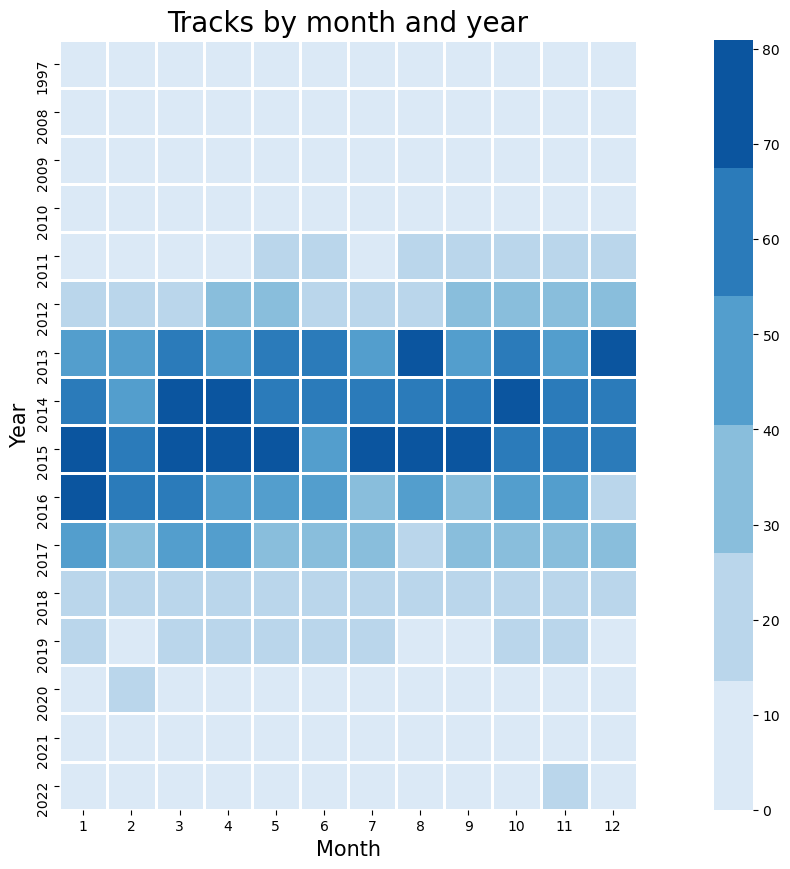

In [35]:
mon = pd.Series(pd.DatetimeIndex(track_df['upload_date']).month)
year = pd.Series(pd.DatetimeIndex(track_df['upload_date']).year)
board = pd.concat([mon, year], axis = 1)
board.columns = ['month', 'year']
board = board.groupby(['month', 'year']).size().reset_index(name = 'count')

df_monthly = board.pivot(index = 'year', columns = 'month', values = 'count').fillna(0).astype(int)
f, ax = plt.subplots(figsize = (20, 10))
cmap = sns.color_palette("Blues")

monthly_sessions = sns.heatmap(df_monthly, 
                    fmt = "d", 
                    linewidths = 1, 
                    ax = ax, 
                    cmap = cmap, 
                    square = True)

ax.axes.set_title("Tracks by month and year", fontsize = 20)
ax.set_xlabel("Month", fontsize = 15)
ax.set_ylabel("Year", fontsize = 15)
plt.show()

As you can see, before 2014, there are rare music production uploaded on SoundCloud because this platform has just been released in 2008.   
Then, users uploaded more tracks from 2013 to 2018.   
Later on, Users rarely upload music on this platform again.

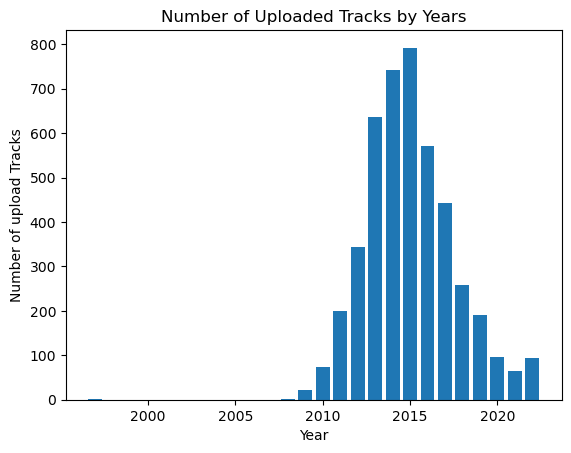

In [36]:
track_df['year'] = pd.to_numeric(pd.DatetimeIndex(track_df['upload_date']).year)
track_year = (Counter(track_df['year']))
plt.bar(track_year.keys(), track_year.values())
plt.xticks()
plt.xlabel('Year')
plt.ylabel('Number of upload Tracks')
plt.title('Number of Uploaded Tracks by Years')
plt.show() 

Number of uploaded tracks is easily observed to peak from 2013 to 2018, espeacially in 2015

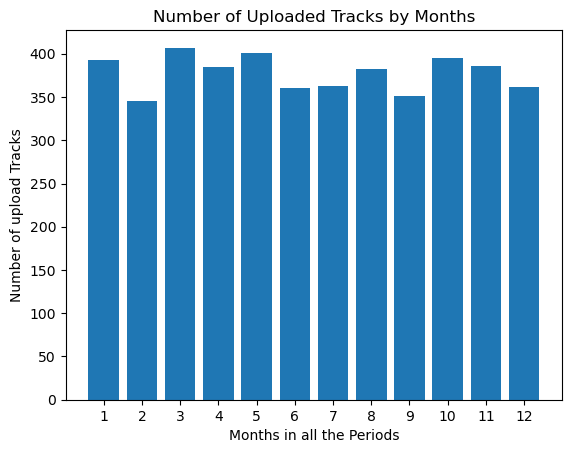

In [37]:
track_df['month'] = pd.to_numeric(pd.DatetimeIndex(track_df['upload_date']).month)
track_month = (Counter(track_df['month']))
month = set(track_df['month'])
sample_set = frozenset(month)
month = list(sample_set)
plt.bar(track_month.keys(), track_month.values())
plt.xlabel('Months in all the Periods')
plt.ylabel('Number of upload Tracks')
plt.xticks(month)
plt.title('Number of Uploaded Tracks by Months')
plt.show() 

However, number of tracks uploaded monthly is still the same when we analyse from the first and the third graph above.

**References**    
Title of news: SoundCloud Revenue And Usage Statistics (2022)  
Url: https://www.businessofapps.com/data/soundcloud-statistics/

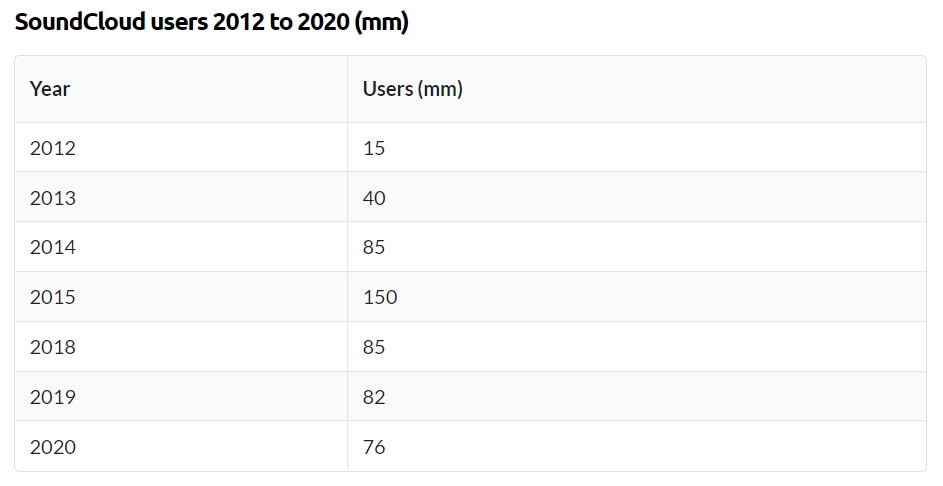

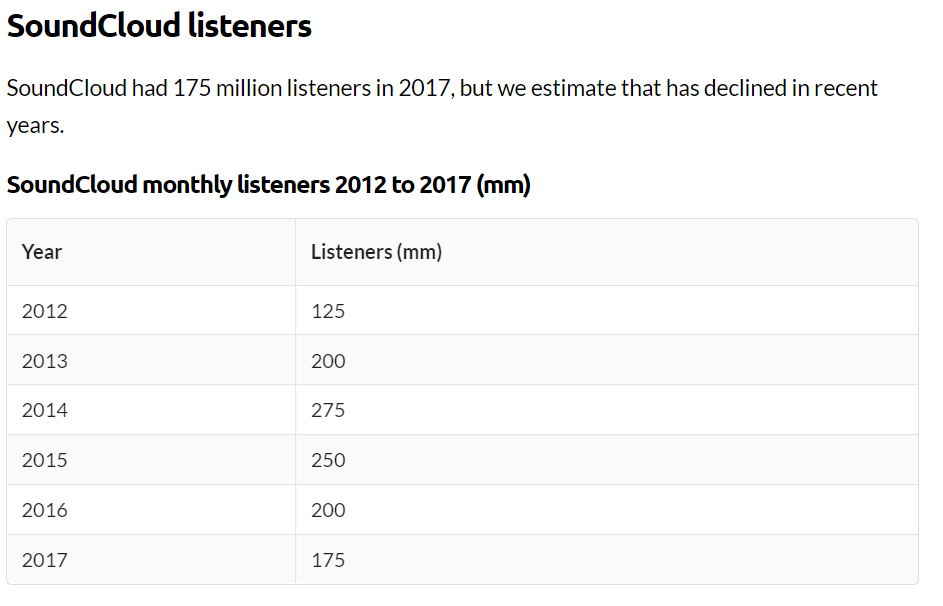

**Answer:** From over analysis and references above, it is proved and convinced that the trend of tracks upload on SoundCloud was trendy in terms of 6 years from 2013.

---

**Question: How was the trend of favorite musics through years?**

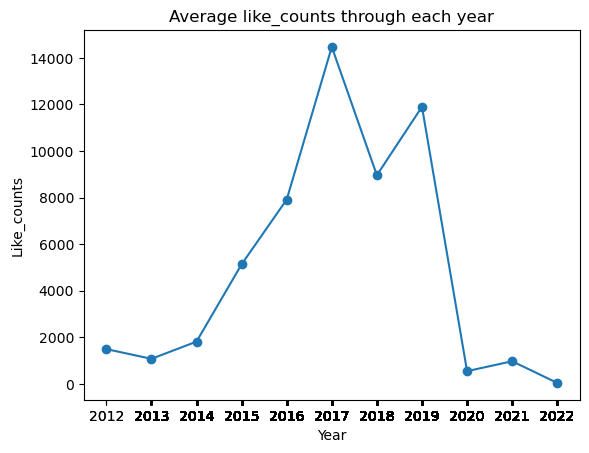

In [38]:
playlist_df['year'] = pd.DatetimeIndex(playlist_df['create_date']).year
temp_df = playlist_df[['year','likes_count']]
final_df = temp_df.groupby('year').mean()
plt.plot(final_df, marker = 'o')
plt.xlabel('Year')
plt.ylabel('Like_counts')
plt.title("Average like_counts through each year")
plt.xticks(playlist_df['year'])
plt.show()

**Answer:** The line chart shows that tracks frequently receive more likes in 2015- 2019, because SoundCloud was one of the most favorite music platforms at that time.

# Apply Linear Regression to Predict number of Playtimes by number of Like

First, we have the formula of correlation of number of playtime and number of likes of tracks here:  
>>>>>>**<font size="10">y = $\alpha$.x + $\beta$</font>** 

- y is variable of number of playtimes  
- x is variable of number of likes  
- $\alpha$ is slope of formula  
- $\beta$ is a constant

In [39]:
def getTheta(x, y):
    a = np.transpose(x) @ x
    b = np.linalg.inv(a)
    c = np.transpose(x) @ y
    Theta = b @ c
    return Theta

In [40]:
y = np.array(track_df['plays_count'])
x = np.array(track_df['likes_count'])
list_none = np.array([1 for i in range(len(x))])
X = []
X.append(list_none)
X.append(x)
X = np.transpose(X)
Theta = getTheta(X, y)
Theta

array([-3.54539854e+05,  7.74209025e+01])

Actually, now we have $\beta$ = -3.54539854e+05 and $\alpha$ = 7.74209025e+01

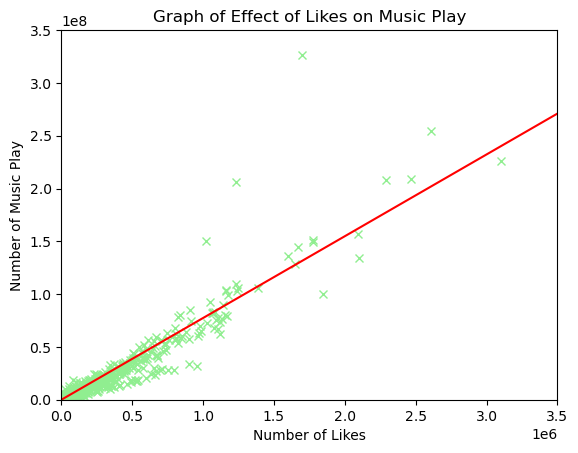

In [41]:
plt.plot(x, y, "x", color = '#90EE90')
t = np.linspace(min(x), max(x) + 20000000, 50)
model = [Theta * ti for ti in t]
plt.plot(t, model, color = 'red')
plt.xlim([0, 3500000])
plt.xlabel('Number of Likes')
plt.ylim([0, 350000000])
plt.ylabel('Number of Music Play')
plt.title('Graph of Effect of Likes on Music Play')
plt.show()

The red line presented the formula **y = $\alpha$.x + $\beta$**  
Actually **y $\approx$ 77.4 * x + 3.54539854e+05**  
Due to this formula, we can see the slope $\alpha$ (77.4) is positive and really high, which means the more likes tracks get, the more playtimes receive  
Also, $\beta$ (3.54539854e+05) is big positive number which relates that the statements we tried to convinced is true.  
Finally, we could use this formula to predict closely number of playtimes or number of likes of a track.

---

In [42]:
x = track_df[~track_df['comments_count'].isnull()]
y = np.array(x['plays_count'])
x = x['comments_count']
x = np.array(pd.to_numeric(x))

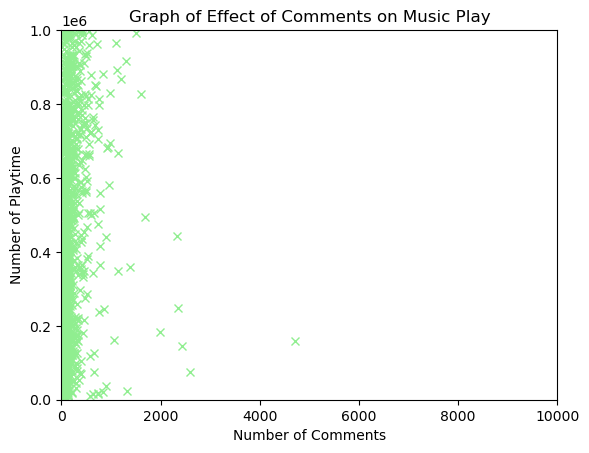

In [43]:
plt.plot(x, y, "x", color = '#90EE90')
plt.xlim([0, 10000])
plt.xlabel('Number of Comments')
plt.ylim([0, 1000000])
plt.ylabel('Number of Playtime')
plt.title('Graph of Effect of Comments on Music Play')
plt.show()

Number of playtimes is not affected by number of comments on the track.  
We could observed, the wide range of playtimes frequently receives under 1000 comments.

---

**Question: What is the average tracks per playlist**

In [44]:
mean_numtrack = playlist_df['tracks_count'].mean()
median_numtrack = playlist_df['tracks_count'].median()
mode_numtrack = playlist_df['tracks_count'].mode()
print(mode_numtrack)

0    500
dtype: int64


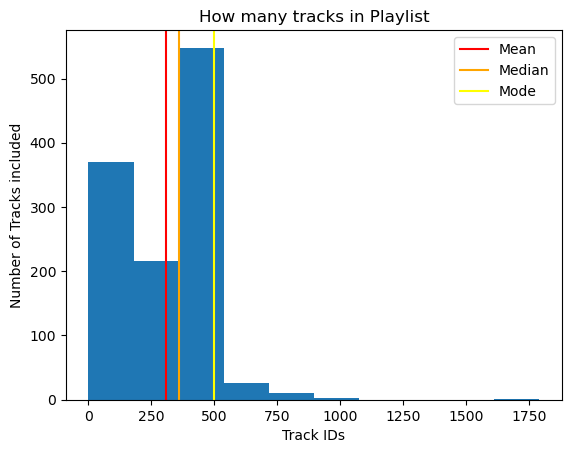

In [45]:
plt.hist(playlist_df['tracks_count'], 10)
plt.title('How many tracks in Playlist')
plt.axvline(x = mean_numtrack, color = 'red', label = 'Mean')
plt.axvline(x = median_numtrack, color = 'orange', label = 'Median')
plt.axvline(x = 500, color = 'yellow', label = 'Mode')
plt.xlabel("Track IDs")
plt.ylabel("Number of Tracks included")
plt.xticks()
plt.legend()
plt.show()

**Answer:**   
So the average tracks per playlist is 308 tracks.  
The median value of tracks per playlist is 360 tracks.  
500 is the most frequent value occuring in the playlists.  
In conclusion, a playlist may include a big number of tracks about 360 to 500 tracks.

---

**Question: Is it true that if the more likes_count playlist has, the more track_counts playlist has.**

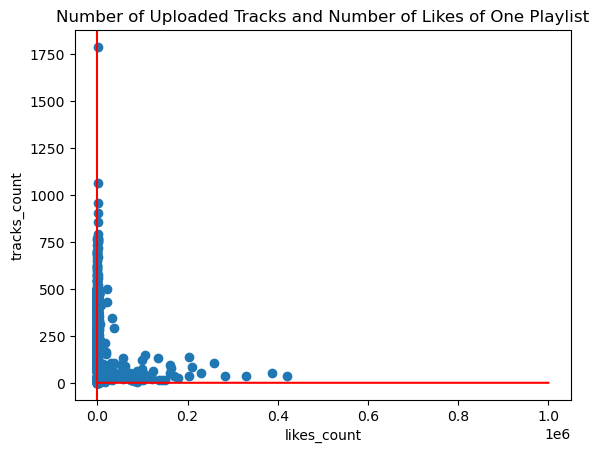

In [46]:
x = np.arange(0, 1000000)
a = 10000000
b = 10000000
y = 1 / (a * x + b)
plt.plot(x, y, color = 'red')
plt.axvline(x = 0, color = 'red')
plt.scatter(playlist_df['likes_count'], playlist_df['tracks_count'])
plt.xlabel('likes_count')
plt.ylabel('tracks_count')
plt.title('Number of Uploaded Tracks and Number of Likes of One Playlist')
plt.show()

**Answer:**   
As you can see, it is false that the more likes_count playlist has, the more track_counts playlist has.  
If it is true, the bigger the likes_count is, the bigger the tracks_count must be.   
But in the above chart, you can see clearly that it not true.